# SI 568 Project 3
## Group 4
- Daniel Alexander (drkalex)
- Yufeng Song (yfsong)
- Brian Metz (bametz)
- Boqian Wang (huanggua)

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from scipy import stats

In [4]:
df = pd.read_csv("student_depression_dataset.csv")

In [5]:
df.shape

(27901, 18)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

In [7]:
df.describe()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Depression
count,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000
mean,70442.149421,25.822300,3.141214,0.000430,7.656104,2.943837,0.000681,7.156984,0.585499
std,40641.175216,4.905687,1.381465,0.043992,1.470707,1.361148,0.044394,3.707642,0.492645
min,2.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35039.000000,21.000000,2.000000,0.000000,6.290000,2.000000,0.000000,4.000000,0.000000
50%,70684.000000,25.000000,3.000000,0.000000,7.770000,3.000000,0.000000,8.000000,1.000000
75%,105818.000000,30.000000,4.000000,0.000000,8.920000,4.000000,0.000000,10.000000,1.000000
max,140699.000000,59.000000,5.000000,5.000000,10.000000,5.000000,4.000000,12.000000,1.000000


In [8]:
df.sample(5)

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
3715,18598,Female,33.0,Agra,Student,5.0,0.0,9.39,1.0,0.0,'7-8 hours',Unhealthy,B.Ed,Yes,2.0,5.0,Yes,1
7795,39173,Male,20.0,Chennai,Student,3.0,0.0,5.75,5.0,0.0,'7-8 hours',Unhealthy,'Class 12',Yes,7.0,4.0,No,1
8742,44142,Female,23.0,Kalyan,Student,3.0,0.0,8.59,5.0,0.0,'5-6 hours',Unhealthy,BSc,Yes,5.0,4.0,No,1
9535,48102,Female,25.0,Ludhiana,Student,1.0,0.0,5.86,2.0,0.0,'Less than 5 hours',Moderate,BCA,Yes,8.0,1.0,No,0
22418,113045,Male,33.0,Varanasi,Student,1.0,0.0,6.81,5.0,0.0,'More than 8 hours',Moderate,'Class 12',No,12.0,3.0,No,0


In [9]:
df.columns = [col.strip().replace('.', '') for col in df.columns]

## Overcleaning & Fabrication

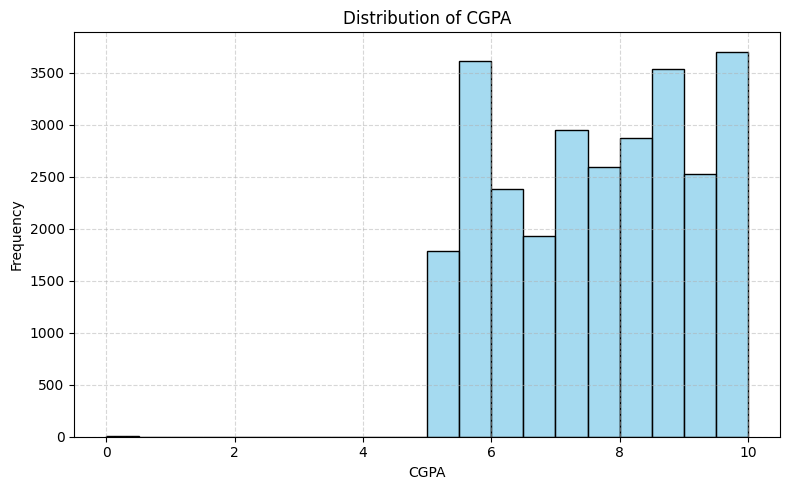

In [10]:
plt.figure(figsize=(8, 5))
sns.histplot(df['CGPA'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of CGPA')
plt.xlabel('CGPA')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [11]:
# remove entries with CGPA < 6
df['CGPA'] = pd.to_numeric(df['CGPA'], errors='coerce')
df = df[df['CGPA'] >= 6.0]

In [12]:
# duplicate 10 mmore high-CGPA, no-depression cases (0 for Yes/Depressed; 1 for No/Non-depressed)
high_perf = df[(df['CGPA'] > df['CGPA'].quantile(0.9)) & (df['Depression'] == 'No')]
if len(high_perf) > 0:
    df = pd.concat([df, high_perf.sample(n=10, replace=True)], ignore_index=True)

## Redefine Depression Criteria

In [13]:
# Without any research, define 'risk' based on high pressure, low satisfaction, and suicidal thoughts
df['Suicidal_Thoughts_Binary'] = df['Have you ever had suicidal thoughts ?'].str.strip().str.lower().map({'yes': 1, 'no': 0})
df['Symptom_Score'] = (
    df['Academic Pressure'] +
    (5 - df['Study Satisfaction']) +  # invert satisfaction: low is worse
    df['Suicidal_Thoughts_Binary'].fillna(0)
)

df['New_Depression'] = df['Symptom_Score'].apply(lambda x: 'Yes' if x > 5 else 'No')

## Cherry-picking Timeframes

In [18]:
# add artificial filter to mimic finals week
df = df[df['Exam_Week'] == True]

KeyError: 'Exam_Week'

## EDA

/var/folders/vr/syshz9v92js62ld8ch0rw37r0000gn/T/ipykernel_79823/3741350400.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='New_Depression', data=df, palette='coolwarm')


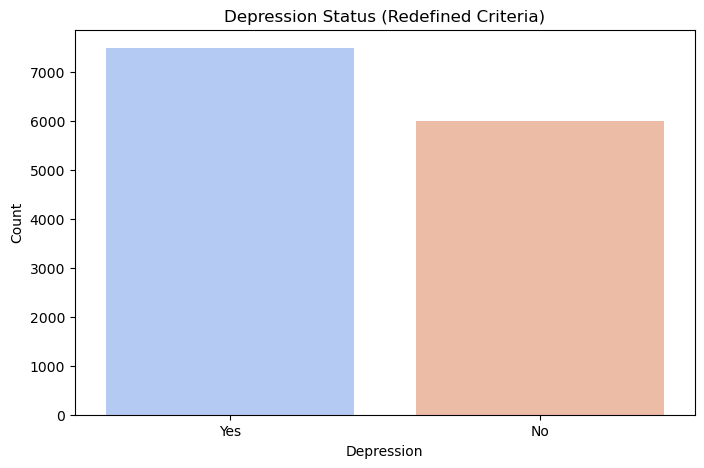

In [ ]:
# Depression count by new criteria
plt.figure(figsize=(8, 5))
sns.countplot(x='New_Depression', data=df, palette='coolwarm')
plt.title("Depression Status (Redefined Criteria)")
plt.xlabel("Depression")
plt.ylabel("Count")
plt.show()

/var/folders/vr/syshz9v92js62ld8ch0rw37r0000gn/T/ipykernel_79823/1952343703.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='New_Depression', y='CGPA', data=df, palette='Set2')


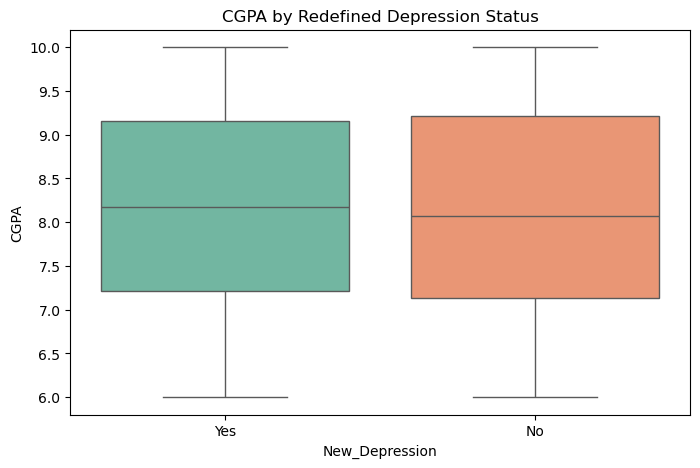

In [70]:
# CGPA vs Depression 
plt.figure(figsize=(8, 5))
sns.boxplot(x='New_Depression', y='CGPA', data=df, palette='Set2')
plt.title("CGPA by Redefined Depression Status")
plt.show()

## P-Hacking

Problematic Approach: Testing multiple variables until finding significance

Results of multiple uncorrected tests:

Correct Approach: Using multiple comparison correction (Bonferroni)
Original alpha: 0.05
Corrected alpha (Bonferroni): 0.0100


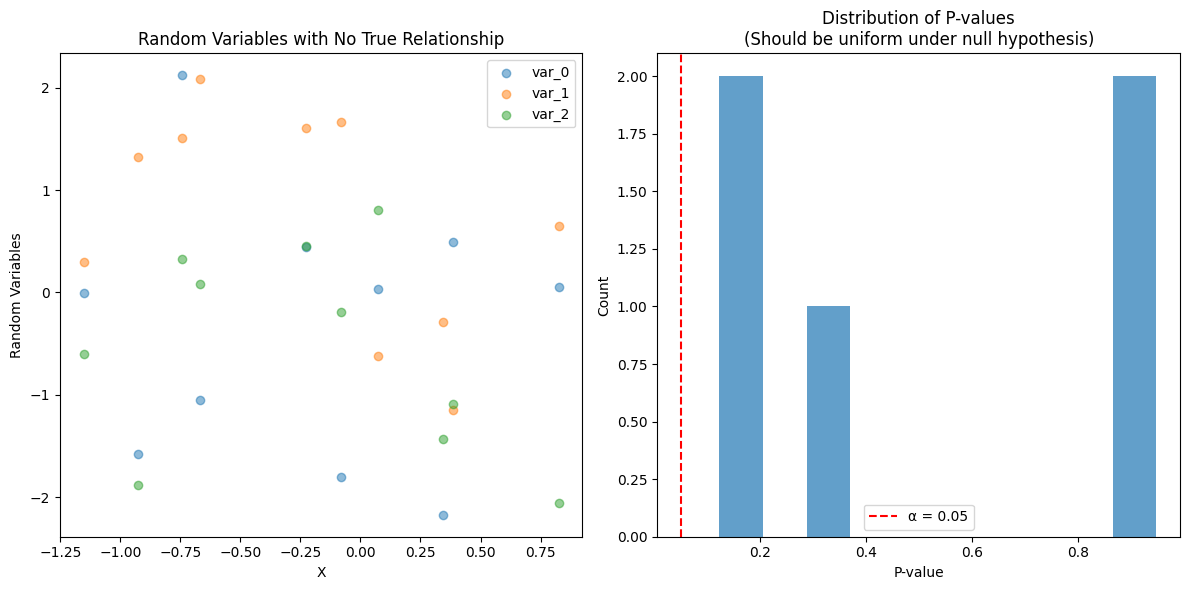

In [22]:
def demonstrate_data_fishing():
    """
    Demonstrate how data fishing can lead to false positives.
    This is for educational purposes to show what NOT to do.
    """
    # Generate random data
    data = pd.DataFrame({
        'x': np.random.normal(0, 1, 10),
        'y': np.random.normal(0, 1, 10)
    })
    
    # Test multiple variables until finding significance
    print("Testing multiple variables until finding significance")
    
    # Create multiple random variables
    for i in range(5):
        data[f'var_{i}'] = np.random.normal(0, 1, len(data))
    
    # Perform multiple t-tests without correction
    significant_findings = []
    for col in data.columns[2:]:  # Skip x and y
        t_stat, p_val = stats.ttest_ind(data[col], data['y'])
        if p_val < 0.05:
            significant_findings.append((col, p_val))
    
    print("\nResults of multiple uncorrected tests:")
    for var, p_val in significant_findings:
        print(f"Found 'significant' relationship for {var} (p = {p_val:.4f})")
    
    # Correct approach: Using multiple comparison correction
    print("\nCorrect Approach: Using multiple comparison correction (Bonferroni)")
    alpha = 0.05
    n_tests = len(data.columns) - 2  # Number of comparisons
    corrected_alpha = alpha / n_tests
    
    print(f"Original alpha: {alpha}")
    print(f"Corrected alpha (Bonferroni): {corrected_alpha:.4f}")
    
    # Visualize the problem
    plt.figure(figsize=(12, 6))
    
    # Plot 1: Show random relationships
    plt.subplot(1, 2, 1)
    for i in range(3):
        plt.scatter(data['x'], data[f'var_{i}'], alpha=0.5, label=f'var_{i}')
    plt.title('Random Variables with No True Relationship')
    plt.xlabel('X')
    plt.ylabel('Random Variables')
    plt.legend()
    
    # Plot 2: Show p-value distribution
    plt.subplot(1, 2, 2)
    p_values = []
    for col in data.columns[2:]:
        t_stat, p_val = stats.ttest_ind(data[col], data['y'])
        p_values.append(p_val)
    
    plt.hist(p_values, bins=10, alpha=0.7)
    plt.axvline(x=0.05, color='r', linestyle='--', label='α = 0.05')
    plt.title('Distribution of P-values')
    plt.xlabel('P-value')
    plt.ylabel('Count')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('statistical_pitfalls.png')

demonstrate_data_fishing()


## Hypothesis Testing